# License

    Jupyter notebook for accessing CUDA
    Copyright (C) 2018 Andre.Brodtkorb@ifi.uio.no

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

#Import packages we need
import numpy as np
import pycuda.compiler as cuda_compiler
from pycuda.gpuarray import GPUArray
import pycuda.driver as cuda_driver

from matplotlib import pyplot as plt

In [2]:
#Initialize CUDA - must be first call to CUDA!
cuda_driver.init()

In [3]:
#Create CUDA context
cuda_device = cuda_driver.Device(0)
print("Using '{:s}'".format(cuda_device.name()))
print(" => compute capability: {:s}".format(str(cuda_device.compute_capability())))
context = cuda_device.make_context()
free, total = cuda_driver.mem_get_info()
print(" => memory: {:d} / {:d} MB available".format(int(free/(1024*1024)), int(total/(1024*1024))))

Using 'Tesla K80'
 => compute capability: (3, 7)
 => memory: 11248 / 11441 MB available


In [10]:
cuda_kernel = """
__global__ void addVectorKernel(float* c, float* a, float* b) {
    unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;
    c[i] = a[i] + b[i];
}

__global__ void addMatrixKernel(float* c, float* a, float* b, int nbCols) {
    unsigned int iX = blockIdx.x*blockDim.x + threadIdx.x;
    unsigned int iY = blockIdx.y*blockDim.y + threadIdx.y;
    unsigned int position = iY*nbCols + iX;
    
    c[position] = a[position] + b[position];
}
"""
module = cuda_compiler.SourceModule(cuda_kernel)
kernel = module.get_function("addMatrixKernel");

<bound method Figure.show of <matplotlib.figure.Figure object at 0x7fc9801a3748>>

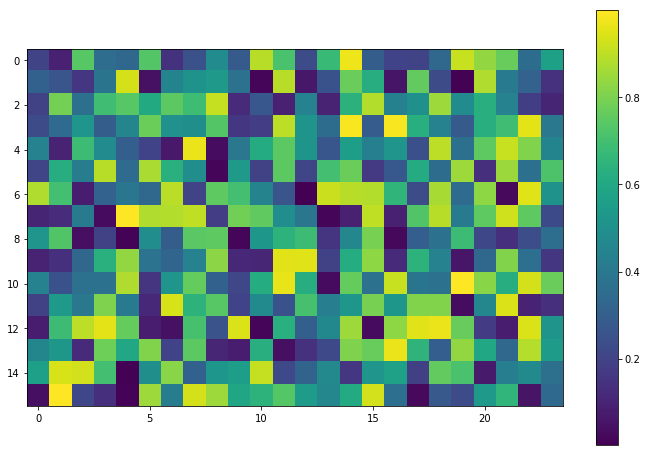

In [14]:
#Size of our test
test_size = (16,24)

#Create test input / output data
a = np.random.random(test_size).astype(np.float32)
b = np.random.random(test_size).astype(np.float32)
c = np.empty_like(a)

fig = plt.figure(figsize=(12,8))
plt.imshow(a)
plt.colorbar()
fig.show

In [15]:
print(a.shape)

(16, 24)


In [16]:
#Upload data to the device
a_g = GPUArray(a.shape, np.float32)
b_g = GPUArray(b.shape, np.float32)
a_g.set(a)
b_g.set(b)

#Allocate output data
c_g = GPUArray(c.shape, np.float32)

In [44]:
#a.shape = [rows, columns] => [y,x]
domain_size = (a.shape[1], a.shape[0])
block_size = (8,8,1)
grid_size = (domain_size[0] // block_size[0], domain_size[1] // block_size[1], 1)

print("Domain size is" + str(domain_size))
print("Block size is" + str(block_size))
print("grid size is" + str(grid_size))

Domain size is(24, 16)
Block size is(8, 8, 1)
grid size is(3, 2, 1)


In [43]:
#Execute program on device
#Be careful of the number of columns, which is domain_size[0]
#in order to be sur to pass an int32, we use np.int32
kernel(c_g, a_g, b_g, np.int32(domain_size[0]), block=block_size, grid=grid_size)

In [39]:
#Copy data from device to host
c_g.get(c)

array([[1.1283193 , 0.31667048, 0.824615  , 1.2768942 , 0.40518612,
        1.3820637 , 0.3156299 , 0.94191575, 1.2726105 , 0.57358146,
        1.2108518 , 1.3740311 , 0.81758   , 1.0975591 , 1.457125  ,
        0.689368  , 0.61287117, 0.2190557 , 0.5079118 , 0.9195402 ,
        1.2072691 , 1.2164472 , 1.3324282 , 1.4888766 ],
       [1.0637007 , 0.6710679 , 0.36069876, 0.4441018 , 0.9951946 ,
        0.44849122, 0.6265882 , 1.1408472 , 1.3695643 , 0.64733994,
        0.4878511 , 0.9902442 , 0.14928755, 0.40210307, 1.4091423 ,
        0.87274516, 0.34248358, 1.3341243 , 0.8079238 , 0.01155278,
        1.243092  , 1.2019053 , 1.0263193 , 1.0576187 ],
       [1.1351644 , 1.3018385 , 0.42558438, 1.102217  , 1.289573  ,
        0.9380795 , 1.7345    , 1.515516  , 1.8124967 , 0.99122524,
        1.1471088 , 0.9489788 , 0.75885546, 0.65181446, 0.9186585 ,
        1.4626269 , 1.0720685 , 0.72604465, 1.7774873 , 0.76774085,
        1.5795324 , 1.2473282 , 0.6539892 , 0.2847533 ],
       [0.257

In [40]:
#Compute reference using Numpy
c_ref = a + b

#Print result
print("C   = ", c)
print("Ref = ", c_ref)
print("Sad = ", np.sum(np.abs(c - c_ref)))

C   =  [[1.1283193  0.31667048 0.824615   1.2768942  0.40518612 1.3820637
  0.3156299  0.94191575 1.2726105  0.57358146 1.2108518  1.3740311
  0.81758    1.0975591  1.457125   0.689368   0.61287117 0.2190557
  0.5079118  0.9195402  1.2072691  1.2164472  1.3324282  1.4888766 ]
 [1.0637007  0.6710679  0.36069876 0.4441018  0.9951946  0.44849122
  0.6265882  1.1408472  1.3695643  0.64733994 0.4878511  0.9902442
  0.14928755 0.40210307 1.4091423  0.87274516 0.34248358 1.3341243
  0.8079238  0.01155278 1.243092   1.2019053  1.0263193  1.0576187 ]
 [1.1351644  1.3018385  0.42558438 1.102217   1.289573   0.9380795
  1.7345     1.515516   1.8124967  0.99122524 1.1471088  0.9489788
  0.75885546 0.65181446 0.9186585  1.4626269  1.0720685  0.72604465
  1.7774873  0.76774085 1.5795324  1.2473282  0.6539892  0.2847533 ]
 [0.2571902  1.0098451  1.1434008  0.3604671  0.7671746  1.4266737
  0.84600925 1.342627   1.1867422  0.33216226 0.68031734 1.7382768
  0.7438729  0.5456361  1.6226261  1.0092031  1

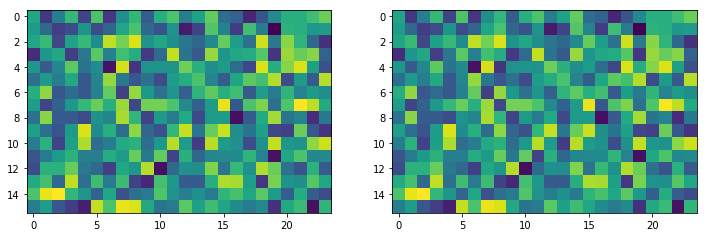

In [42]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(c)
plt.subplot(1,2,2)
plt.imshow(c_ref)

In [8]:
print("shqhin")

shqhin
